In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics_C
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points    = 3
Title         = 'Diabetes'
FUR_Weight    = 0.1
N_consistancy = 25
consist_bound = 0.3

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
Title = Title + ' W:'+ str(FUR_Weight)

In [5]:
# Load Forrester model

Class_data = BB_Model(dataset = 'Diabetes')
                      
#Class_data.df().head()

In [6]:
Class_data.MPL()

0.6883116883116883


MLPClassifier(random_state=RandomState(MT19937) at 0x1B8980C9840)

In [7]:
Class_data.Random_Forest()

0.7662337662337663


RandomForestClassifier(random_state=RandomState(MT19937) at 0x1B8980C9840)

In [8]:
#Class_data.GP()

In [9]:
Class_data.L_Regression()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7987012987012987


LogisticRegression()

In [10]:
print(Class_data.get_features())

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [11]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Class_data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Class_data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Class_data.get_features(),
                   categorical_features = Class_data.get_catagorical(),
                   mode                 = Class_data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [12]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Class_data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Class_data.get_features(),
                     categorical_features = Class_data.get_catagorical(),
                     mode                 = Class_data.get_mode(),
                     sampling_optimize    = "opt")



In [13]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [  3.78013029 119.99511401  68.93648208  20.79315961  77.96416938
  32.20586319   0.47084691  32.94299674]
Std 0:  [  3.32871173  32.21479684  19.68193846  15.85082799 109.23550755
   7.75061192   0.32830011  11.34985578]


In [14]:
# Generate explantion data for Random Forest

Class_Stats   = Feature_Statistics_C(feature_names = Class_data.get_features(),
                                     mode          = Class_data.get_mode(),
                                     classes       = ['Not-Diabetic', 'Diabetic'],
                                     X_train_std   = Class_data.get_X_train_std(),
                                     N_consistancy = N_consistancy)

Class_Stats_2 = Feature_Statistics_C(feature_names = Class_data.get_features(),
                                     mode          = Class_data.get_mode(),
                                     classes       = ['Not-Diabetic', 'Diabetic'],
                                     X_train_std   = Class_data.get_X_train_std())


if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight)
       
    f_predict = Class_data.get_Random_Forest().predict_proba(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

#    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    consistancy = URM_Exp.Y_Consistancy(N_points = N_consistancy, std_bound = consist_bound)
    
    URM_Exp.del_1_rel()
    
    del_1_var = URM_Exp.get_del_1_variance()
    
    Class_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         consistancy   = consistancy,
                         del_1_var     = del_1_var)
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight)
       
    f_predict = Class_data.get_L_Regression().predict_proba(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Class_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None)
    


INSTANCE:  0
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


INSTANCE:  1
Acq_Data_nD


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Acq_Data_nD
INSTANCE:  2
Acq_Data_nD
Acq_Data_nD


In [15]:
import matplotlib.pyplot as plt


In [16]:
print(f_predict)
print(e_predict)


[[0.13194224 0.86805776]]
[9.99999999e-01 1.00000004e-05]


In [17]:
Class_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


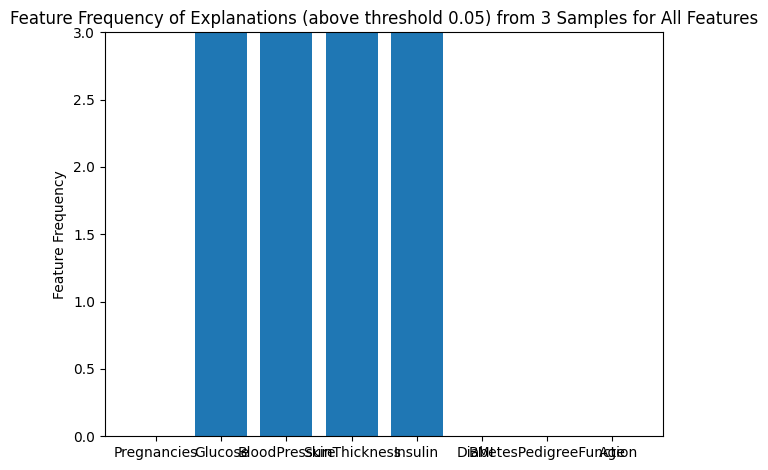

In [18]:
Class_Stats.Frequency_Plot()


In [19]:
Class_Stats.Class_Fidelity()

BB(x) - exp(x) proba dif  Avg:  0.3979639663280456  var:  0.10798582760379648  max:  0.8648999997042833
Scores:
BB Model Score:   1.0
Exp Model Score:  0.0
BB - Exp Score:   0.0
Fidelity:  0.602


In [20]:
Class_Stats.Jaccard_Values()

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0


top_features True
top_features (3, 8)


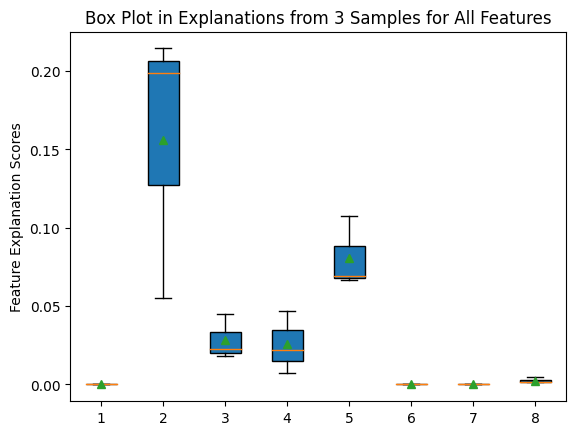

1 -      Pregnancies
2 -      Glucose
3 -      BloodPressure
4 -      SkinThickness
5 -      Insulin
6 -      BMI
7 -      DiabetesPedigreeFunction
8 -      Age


In [21]:
Class_Stats.Box_Plot()


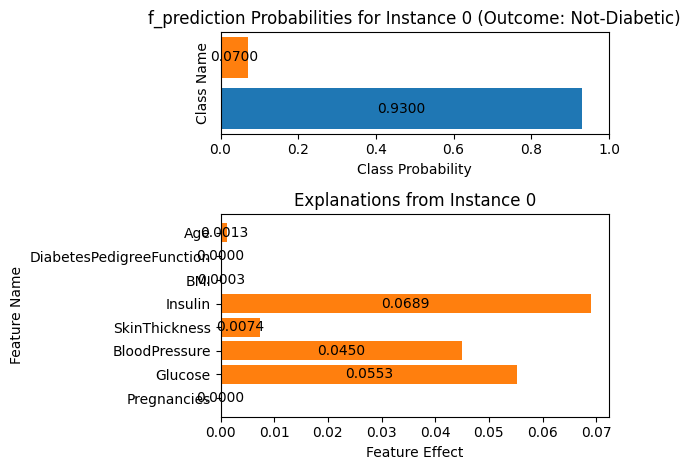

In [22]:
Class_Stats.View_Explanation(instance = 0)

In [23]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[7.54155450e-06 2.89324991e-01 2.50058553e-02 1.74412438e-02
 5.89470310e-02 2.36560066e-04 7.75517661e-10 1.42400922e-03]


In [24]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[1.77289647 1.73387039 1.74032954 1.75043428 1.70276529 1.77173117
 1.77308352 1.76862622]


In [25]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[0.00041031 0.15617814 0.01415738 0.01355989 0.03495499 0.0008957
 0.00031792 0.00201208]


In [26]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[2.88341722e-02 6.16158350e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.09692056e-01 1.09125768e-04 1.09978114e+00]


In [27]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[5.19805526e-06 6.70430950e+00 4.49192537e-01 3.70860515e-01
 4.75313226e-01 1.17980650e-04 5.75961801e-10 2.01044887e-04]


In [28]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[-8.11019248e+00  1.11180516e-02  7.04509139e-04 -7.11093612e-04
 -1.49313035e-03  8.32098836e-01  6.53490542e+01 -5.00602239e-02]


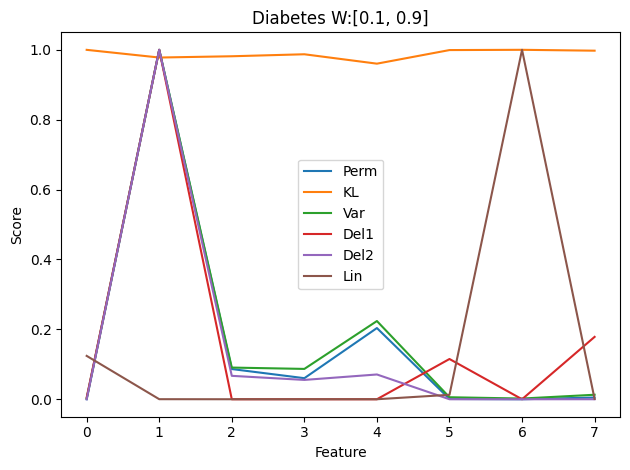

In [29]:
URM_Exp.plot_scores(Title)

In [30]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 4.85352792e-01  8.74318402e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 5.00187487e-01  8.64615569e-01  4.74594052e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [31]:
acq_data.Create_BB_plot()

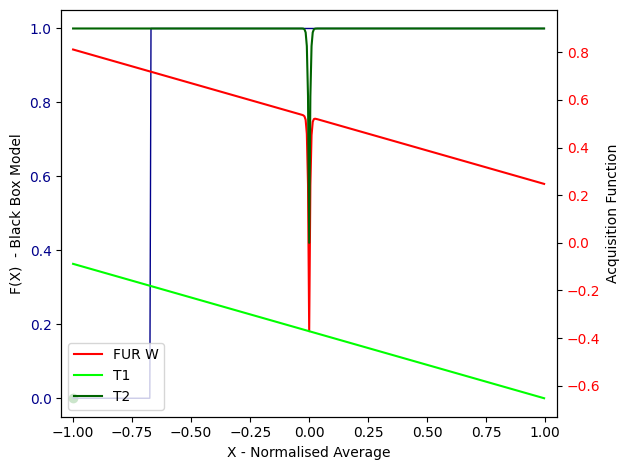

In [32]:
acq_data.plot_point(0)

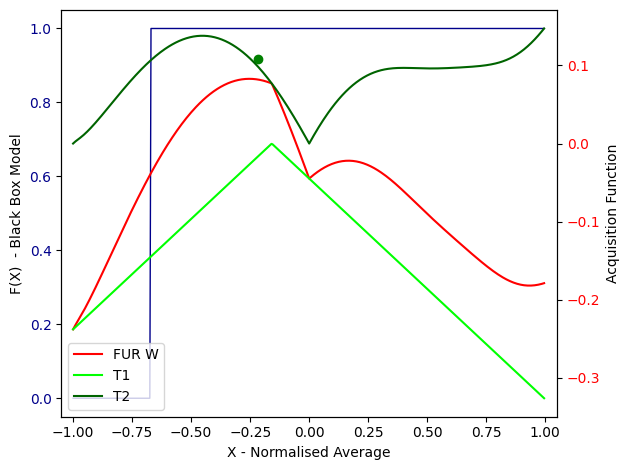

In [33]:
acq_data.plot_point(5)

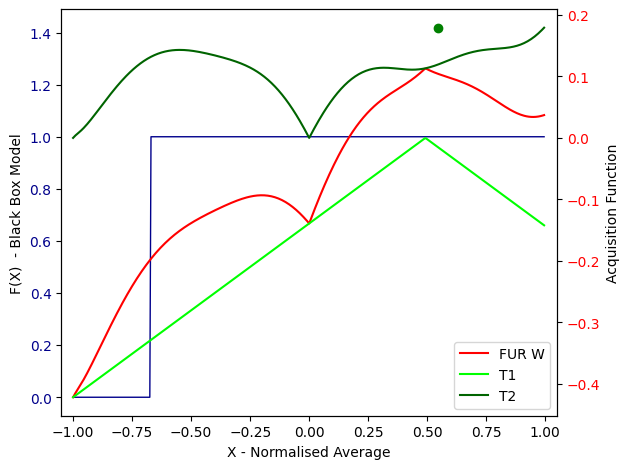

In [34]:
acq_data.plot_point(10)

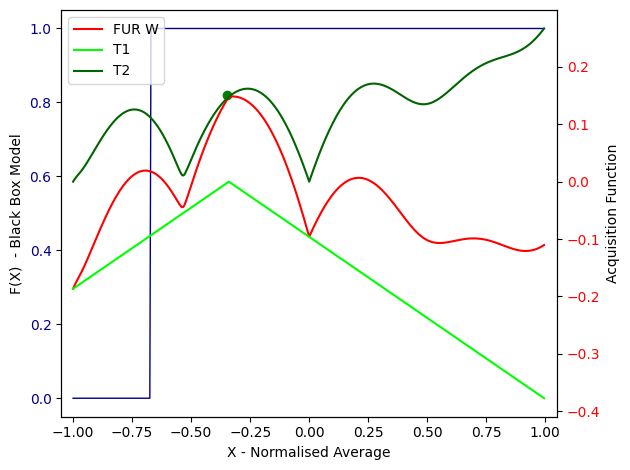

In [35]:
acq_data.plot_point(15)

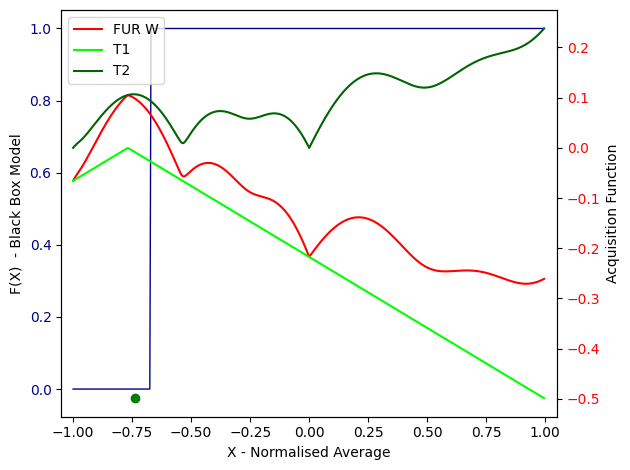

In [36]:
acq_data.plot_point(19)

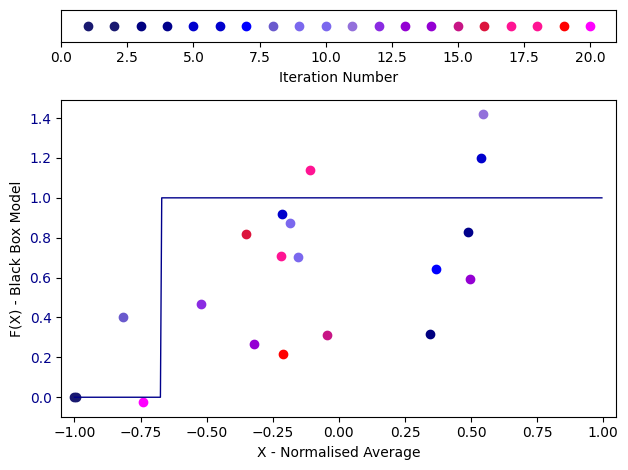

In [37]:
acq_data.plot_all()

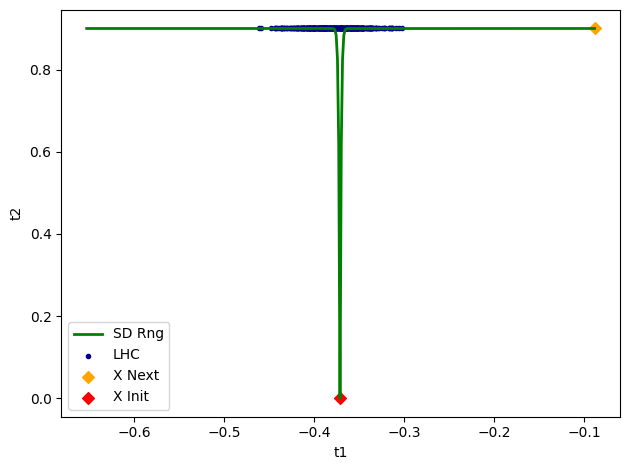

In [38]:
acq_data.plot_t1_t2(0)

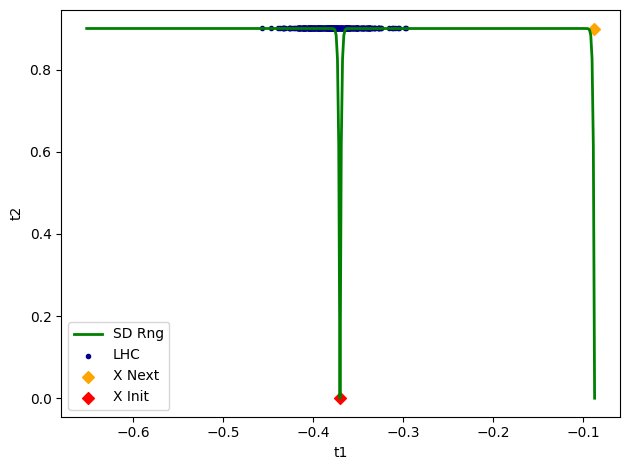

In [39]:
acq_data.plot_t1_t2(1)

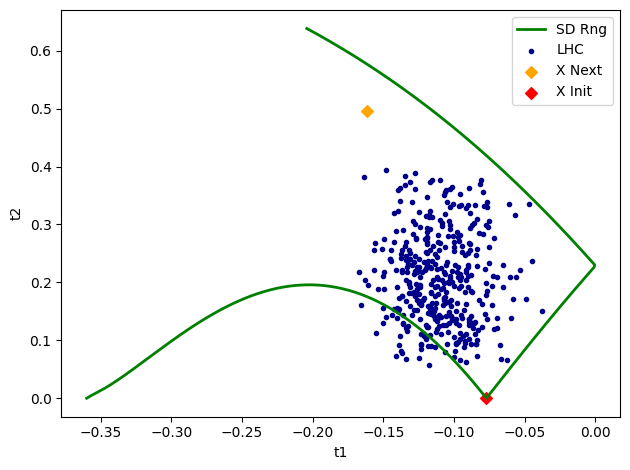

In [40]:
acq_data.plot_t1_t2(2)

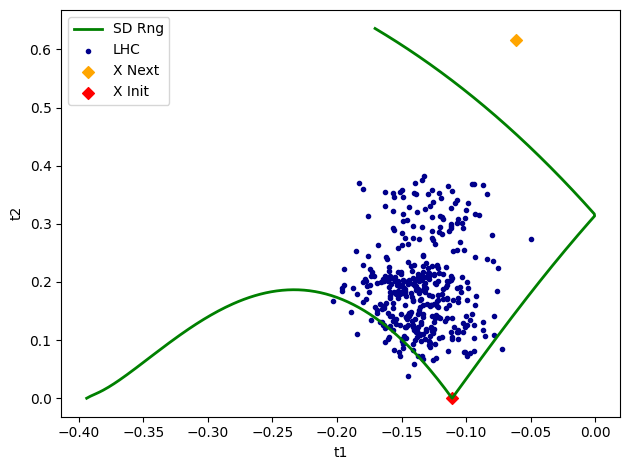

In [41]:
acq_data.plot_t1_t2(3)

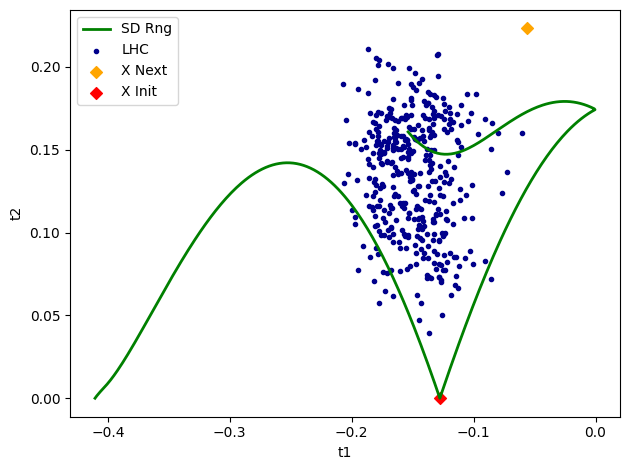

In [42]:
acq_data.plot_t1_t2(4)

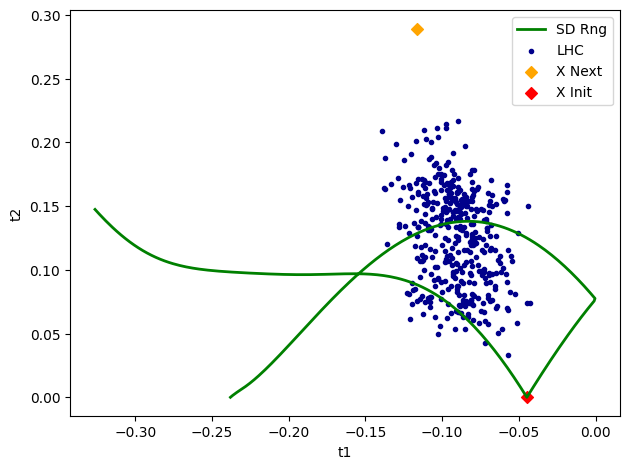

In [43]:
acq_data.plot_t1_t2(5)

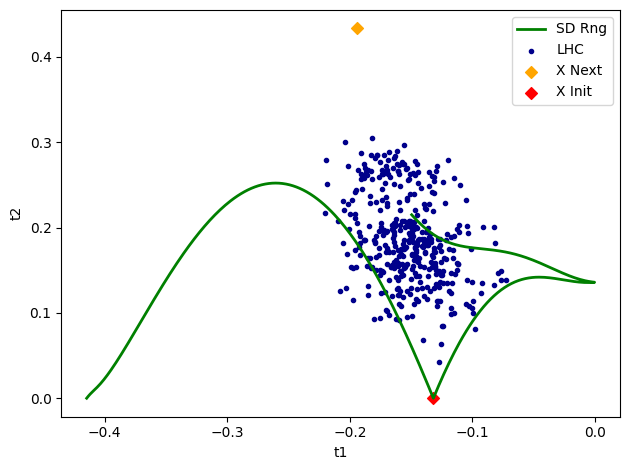

In [44]:
acq_data.plot_t1_t2(6)

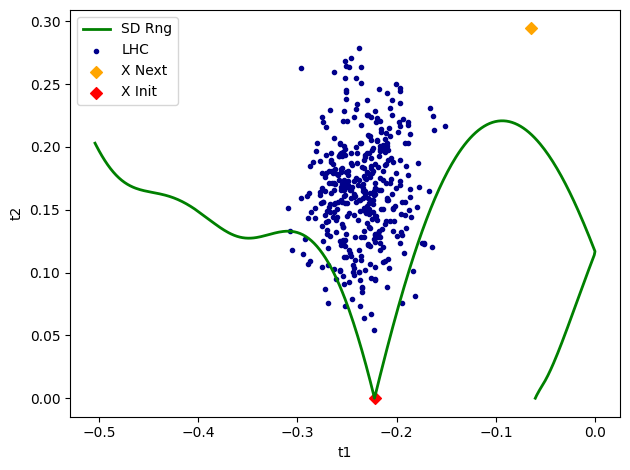

In [45]:
acq_data.plot_t1_t2(7)

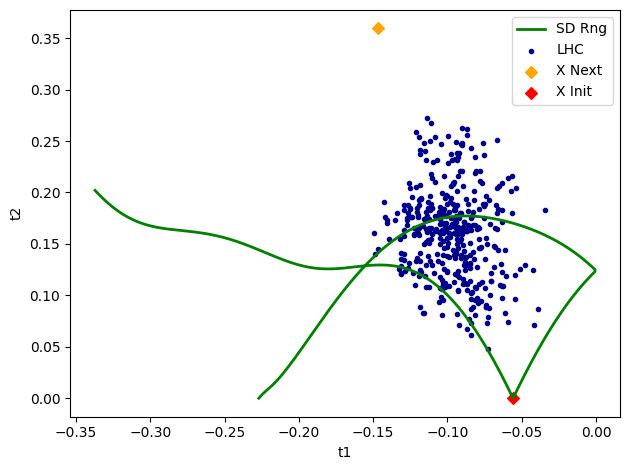

In [46]:
acq_data.plot_t1_t2(8)

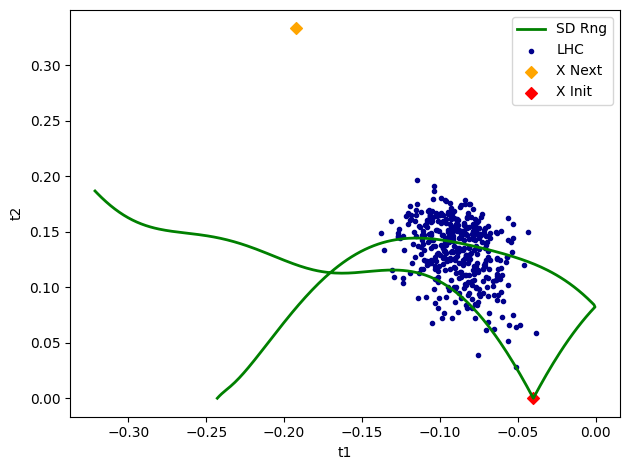

In [47]:
acq_data.plot_t1_t2(9)

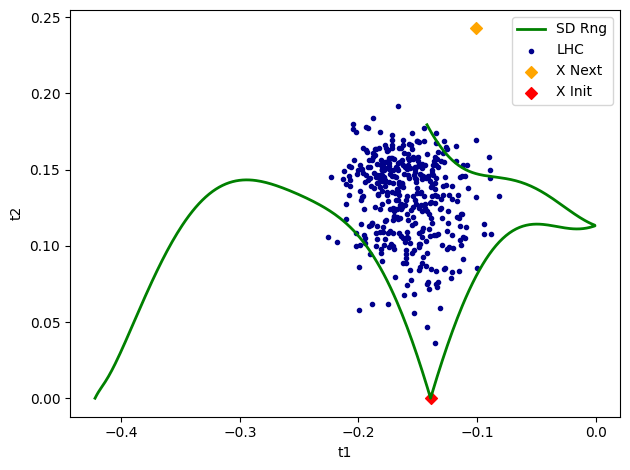

In [48]:
acq_data.plot_t1_t2(10)

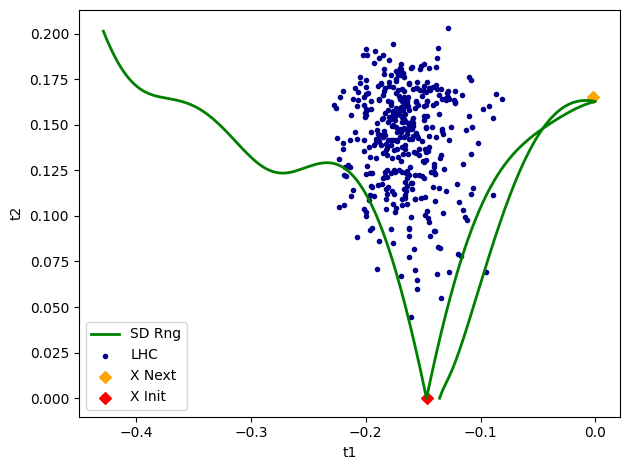

In [49]:
acq_data.plot_t1_t2(11)

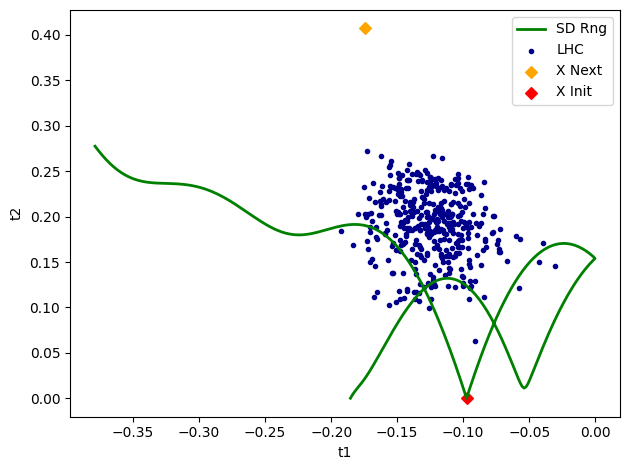

In [50]:
acq_data.plot_t1_t2(12)

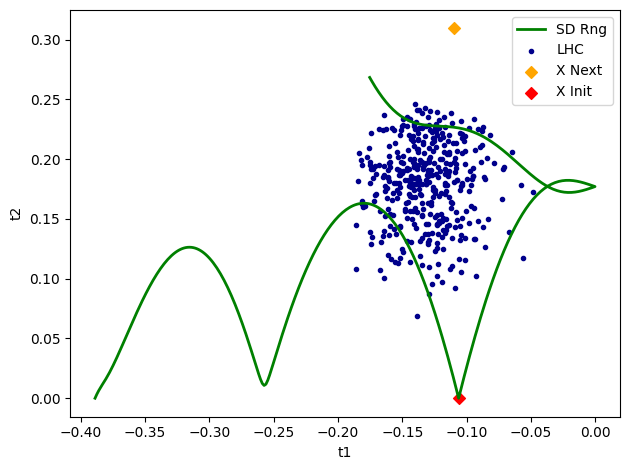

In [51]:
acq_data.plot_t1_t2(13)

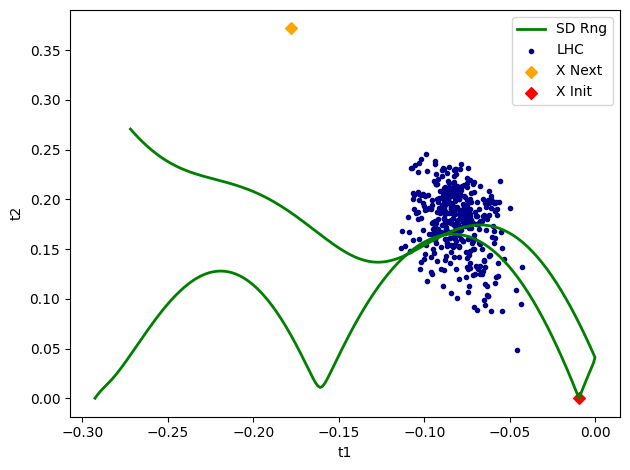

In [52]:
acq_data.plot_t1_t2(14)

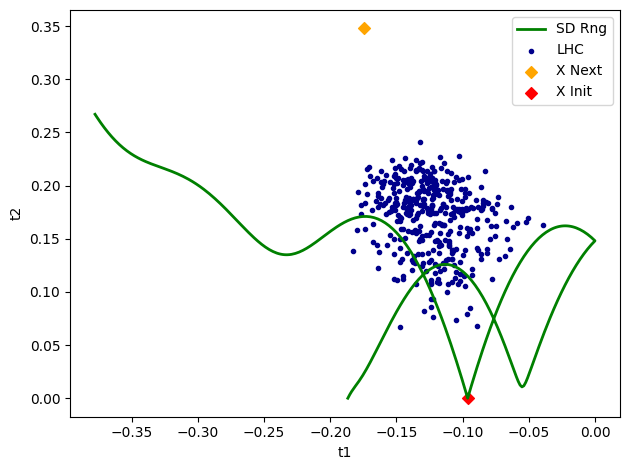

In [53]:
acq_data.plot_t1_t2(15)

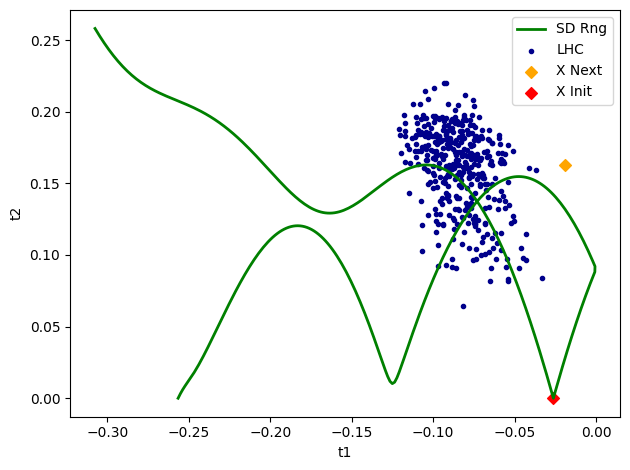

In [54]:
acq_data.plot_t1_t2(16)

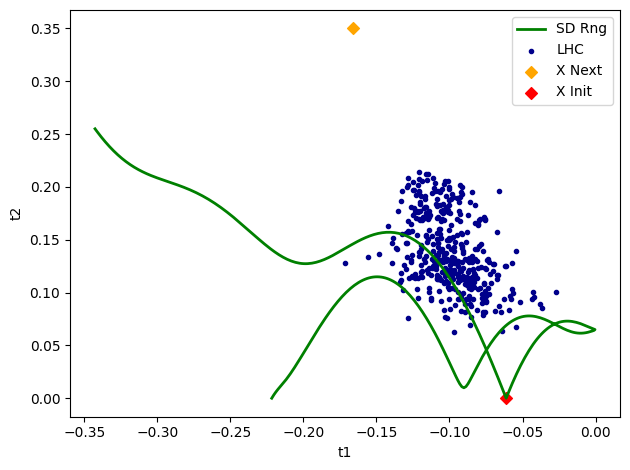

In [55]:
acq_data.plot_t1_t2(17)

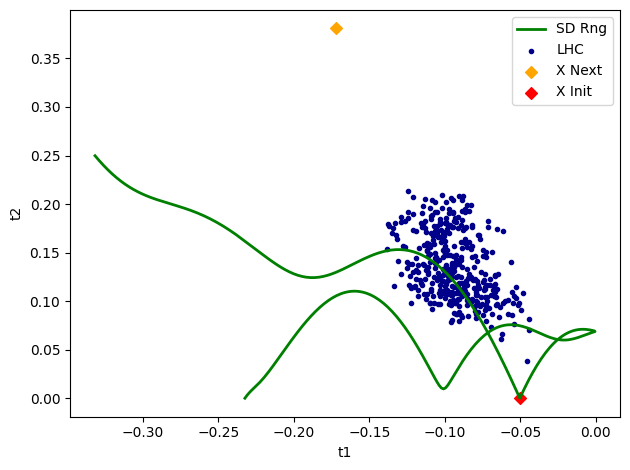

In [56]:
acq_data.plot_t1_t2(18)

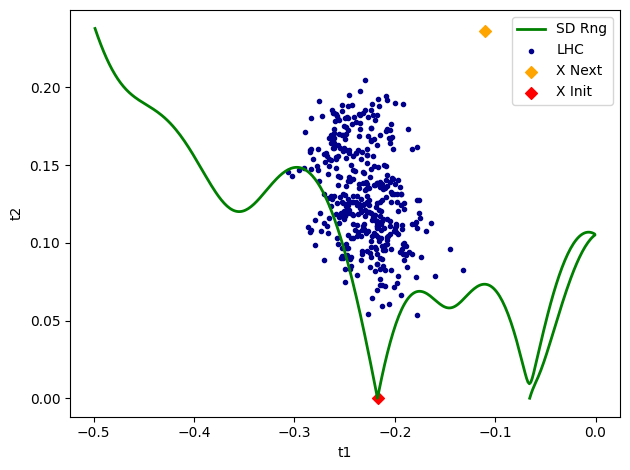

In [57]:
acq_data.plot_t1_t2(19)

In [58]:
Class_Stats.Class_Fidelity()

print('Fidelity: ', Class_Stats.fidelity)

BB(x) - exp(x) proba dif  Avg:  0.3979639663280456  var:  0.10798582760379648  max:  0.8648999997042833
Scores:
BB Model Score:   1.0
Exp Model Score:  0.0
BB - Exp Score:   0.0
Fidelity:  0.602
Fidelity:  0.6020360336719544


In [59]:
Class_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Class_Stats.jaccard_similarities)

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0
Jaccard:  1.0


In [60]:
Class_Stats.Consistancy(std_bound = consist_bound, plot=True, title = Title)

Consistancey Std/P Pert:  0.3 : 0.011089303346970846
Perturbed Changes: 0.0 0.0 0.0 0.0


In [61]:
Class_Stats.Compare_Models (model_b = Class_Stats_2)

mean_scores:  [1.18998233e-05 1.56207122e-01 2.85264977e-02 2.55682570e-02
 8.09847313e-02 3.63430225e-04 1.10720503e-09 2.46756668e-03]
mean_scores_d:  [6.14276571e-06 7.75701072e-02 2.10110639e-02 1.78125716e-02
 6.34742521e-02 2.03839643e-04 5.93617739e-10 1.52203494e-03]
Score Diff Mean:  [0.31908157 0.33637585 0.15171182 0.1787814  0.12121419 0.28133097
 0.30196403 0.23699904]
Score Diff SD:    [0.03563702 0.42226148 0.4003518  0.203805   0.08237793 0.05219541
 0.09618646 0.04903606]
 Model Feature Correlation:  0.9681991718448975


In [62]:
Class_Stats.Calibration()

Brier_Score:  0.33332666676639083


In [63]:
Class_Stats.delete_one()

mean_variance [3.28922652e-03 6.16741388e-01 2.02077371e-01 6.59012910e-02
 3.33260653e-02 7.75089415e-02 1.38446194e-05 1.22321890e-01]
Mean scores: [1.18998233e-05 1.56207122e-01 2.85264977e-02 2.55682570e-02
 8.09847313e-02 3.63430225e-04 1.10720503e-09 2.46756668e-03]
sort_order [6 0 5 7 3 2 4 1]
norm sorted_scores [3.01147627e-08 3.23662145e-04 9.88490358e-03 6.71151076e-02
 6.95428551e-01 7.75889455e-01 2.20269588e+00 4.24866241e+00]
norm sorted_variance [9.87860591e-05 2.34697477e-02 5.53052607e-01 8.72808209e-01
 4.70228081e-01 1.44189063e+00 2.37792788e-01 4.40065915e+00]
Prediction Variance Feature Deletion 1: [3.28922652e-03 6.16741388e-01 2.02077371e-01 6.59012910e-02
 3.33260653e-02 7.75089415e-02 1.38446194e-05 1.22321890e-01]
Delete 1 error: 0.5475258906799951
Delete 1 Correlation: 0.8277193019336402


In [64]:
Class_Stats.Results_Summary(Title)

Results_Summary: Diabetes W:[0.1, 0.9]
 Model Feature Correlation:  0.9681991718448975
Fidelity:  0.602
Consistancey Std/P Pert:  0.3 : 0.011089303346970846
Delete 1 error:       0.5475258906799951
Delete 1 Correlation: 0.8277193019336402
Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0
Brier_Score:  0.33332666676639083
